In [60]:
import sys
sys.path.append('../../')

import numpy as np
import pandas as pd
import torch as tc


import time
from tqdm import tqdm

#Plotting
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=20)
plt.rcParams['text.usetex'] = True

FILE_PATH = "../../../data/well.txt"


from rcgp.weight_functions import IMQ, partial_y_IMQ
from rcgp.rcgp import TemporalRCGP

N = 3450
dt = 0.014496956020593643


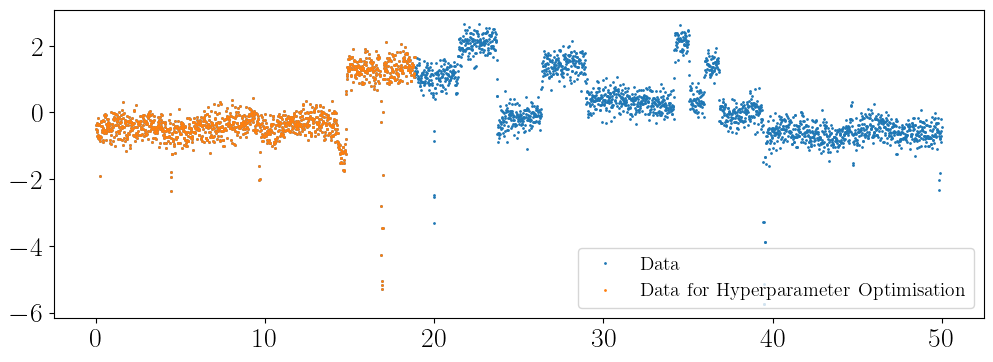

In [181]:
data = np.loadtxt("../../data/well.txt")

data_mean = data.mean()
data_std = data.std()
data = (data - data_mean) / data_std

data_idx_subset = np.arange(50, 3500)
data = tc.from_numpy(data[data_idx_subset]).to(tc.float32)
times = tc.from_numpy(np.linspace(0, 50, len(data))).to(tc.float32)

partial_times = times[:1300].clone()
partial_data = data[:1300].clone()


plt.figure(figsize=(12,4))
plt.plot(times, data, '.', markersize=2, label="Data")
plt.plot(partial_times, partial_data, '.', markersize=2, label='Data for Hyperparameter Optimisation')
plt.legend(fontsize=14)
print("N = {}".format(len(data)))
print("dt = {}".format(times[1] - times[0]))

In [182]:
def weighted_scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):
    S = covs + R
    eps = (Ys - preds).unsqueeze(-1)

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    Ws = (Ws / Ws.sum()).squeeze()
    
    return tc.dot(Ws, energies)

100%|██████████| 25/25 [00:53<00:00,  2.14s/it]

lengthscale :  0.6718264818191528
magnitude :  1.9203765392303467
variance y :  0.029804620891809464


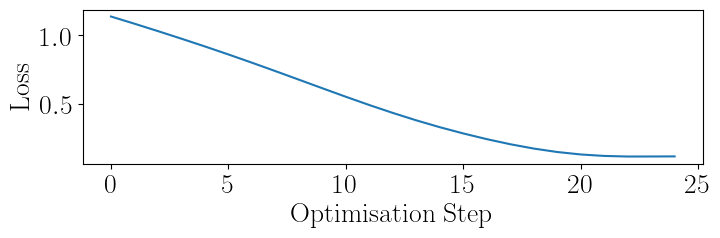

In [183]:
lr = 0.2 #Learning Rate
n_steps=25 #Number of Optimisation Steps
verbose=False #To print loss/params at each # steps
losses = [] #For plotting losses

rtgp = TemporalRCGP(ts=partial_times.reshape(-1,1), Ys=partial_data.reshape(-1,1), p=1)

rtgp.adaptive_c()
rtgp.activate_robustness(func="m_pred")

optimizer = tc.optim.Adam(rtgp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = rtgp.forward()

    loss = weighted_scoring_rule(Ys=partial_data.reshape(-1,1), preds=preds, covs=covs, R=R, Ws=Ws)

    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

    if verbose and step%5==0:
        print(f"---------step {step}----------")
        print("Loss : {}".format(loss.detach().clone()))

        for name, param in rtgp.named_parameters():
            if param.requires_grad:
                print(f"{name}: {param.data}")
        print("-------------------------\n")

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

print("lengthscale : ", rtgp.temporal_lengthscale.item())
print("magnitude : ", rtgp.temporal_magnitude.item())
print("variance y : ", rtgp.var_y.item())

In [184]:
rtgp_inference = TemporalRCGP(ts=times.reshape(-1,1), Ys=data.reshape(-1,1), p=1)

rtgp_inference.temporal_lengthscale = rtgp.temporal_lengthscale.item() 
rtgp_inference.temporal_magnitude = rtgp.temporal_magnitude.item()
rtgp_inference.var_y = rtgp.var_y.item()

rtgp_inference.activate_robustness(func='m_pred')
rtgp_inference.adaptive_c()


with tc.no_grad(): 
    (pred_rtgp, std_rtgp, rtgp_eff), _, _ = rtgp_inference.forward()
    pred_rtgp = pred_rtgp.squeeze().numpy()
    #std_strcgp = std_strcgp.squeeze().numpy()
    std_rtgp = tc.sqrt(rtgp.var_y.clone().detach() + std_rtgp**2).numpy()

(0.0, 50.0)

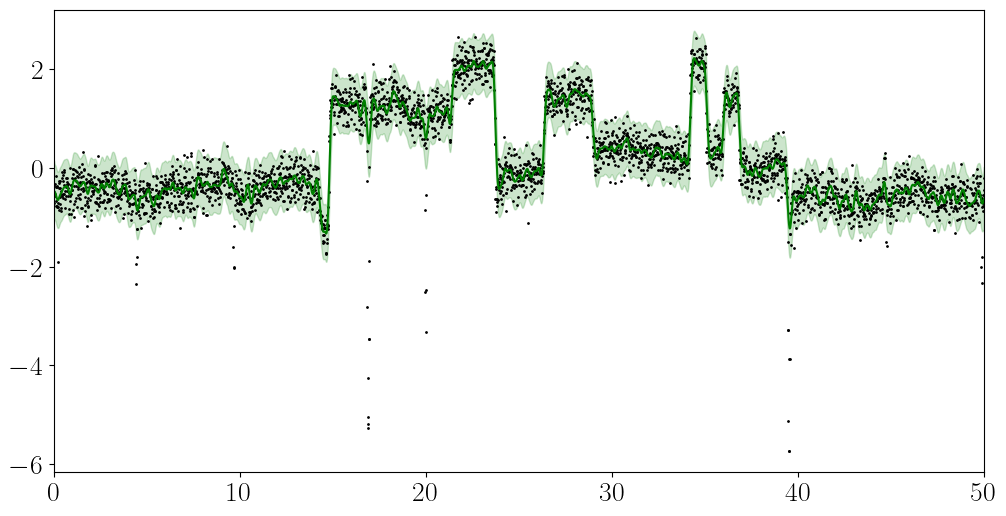

In [185]:
plt.figure(figsize=(12,6))
plt.plot(times, data, '.', color='black', markersize=2)
plt.plot(times, pred_rtgp, color='green')
plt.fill_between(times, pred_rtgp.flatten() - 3 * std_rtgp, pred_rtgp.flatten() + 3 * std_rtgp, color='green', alpha=0.2)
plt.xlim(times[0], times[-1])


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:02<00:00,  1.26s/it]

lengthscale :  0.20735153555870056
magnitude :  2.3434062004089355
variance y :  0.053245335817337036


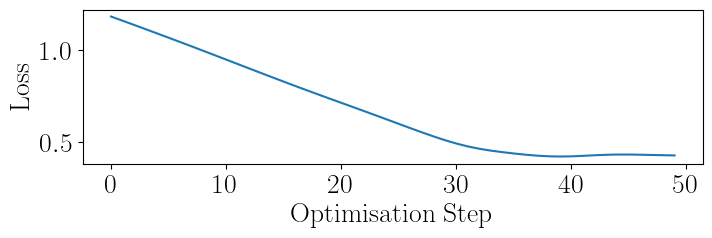

In [194]:
lr = 0.1 #Learning Rate
n_steps=50 #Number of Optimisation Steps
verbose=False #To print loss/params at each # steps
losses = [] #For plotting losses

stgp = TemporalRCGP(ts=partial_times.reshape(-1,1), Ys=partial_data.reshape(-1,1), p=1)

stgp.deactivate_robustness()

optimizer = tc.optim.Adam(stgp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = stgp.forward()

    loss = weighted_scoring_rule(Ys=partial_data.reshape(-1,1), preds=preds, covs=covs, R=R, Ws=Ws)

    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

    if verbose and step%5==0:
        print(f"---------step {step}----------")
        print("Loss : {}".format(loss.detach().clone()))

        for name, param in stgp.named_parameters():
            if param.requires_grad:
                print(f"{name}: {param.data}")
        print("-------------------------\n")

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

print("lengthscale : ", stgp.temporal_lengthscale.item())
print("magnitude : ", stgp.temporal_magnitude.item())
print("variance y : ", stgp.var_y.item())

In [199]:
stgp_inference = TemporalRCGP(ts=times.reshape(-1,1), Ys=data.reshape(-1,1), p=1)

stgp_inference.temporal_lengthscale = stgp.temporal_lengthscale.item()
stgp_inference.temporal_magnitude = stgp.temporal_magnitude.item()
stgp_inference.var_y = stgp.var_y.item()

stgp_inference.deactivate_robustness()


with tc.no_grad(): 
    (pred_stgp, std_stgp, stgp_eff), _, _ = stgp_inference.forward()
    pred_stgp = pred_stgp.squeeze().numpy()
    #std_strcgp = std_strcgp.squeeze().numpy()
    std_stgp = tc.sqrt(stgp.var_y.clone().detach() + std_stgp**2).numpy()


stgp_inference.temporal_lengthscale = stgp.temporal_lengthscale.item() * 5

with tc.no_grad(): 
    (pred_stgp_improved, std_stgp_improved, stgp_eff_improved), _, _ = stgp_inference.forward()
    pred_stgp_improved = pred_stgp_improved.squeeze().numpy()
    #std_strcgp = std_strcgp.squeeze().numpy()
    std_stgp_improved = tc.sqrt(stgp.var_y.clone().detach() + std_stgp_improved**2).numpy()

(0.0, 50.0)

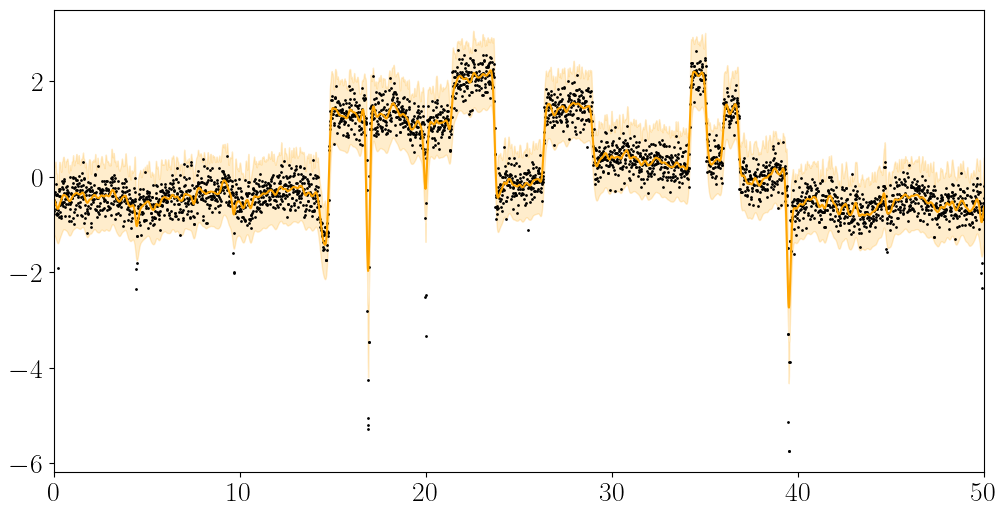

In [202]:
plt.figure(figsize=(12,6))
plt.plot(times, data, '.', color='black', markersize=2)
"""
plt.plot(times, pred_stgp, color='orange')
plt.fill_between(times, pred_stgp.flatten() - 3 * std_stgp, pred_stgp.flatten() + 3 * std_stgp, color='orange', alpha=0.2)
"""
plt.plot(times, pred_stgp_improved, '-', color='orange')
plt.fill_between(times, pred_stgp_improved.flatten() - 3 * std_stgp_improved, pred_stgp.flatten() + 3 * std_stgp_improved, color='orange', alpha=0.2)
plt.xlim(times[0], times[-1])